# Introduction

This notebook uses data from the (OpenPV project)[https://openpv.nrel.gov/] and the US Census to make predictions about what economic and demographic characteristics lead to installation of solar panels. The data used here has been preprocessed before use.

The data is first loaded in, and descriptive statistics are calculated.

In [21]:
# Import needed modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os



In [139]:
# Create OS independent file name

subdir = os.path.join(os.path.curdir, "data")

file_path = os.path.join(subdir, "combined_data.csv")

# Read file
solar_data = pd.read_csv(file_path)

In [140]:
# Normalize solar capacity by population

solar_data['Capacity per capita'] = solar_data['size_kw'] / solar_data['Population']
solar_data['Percent White'] = solar_data['White Population'] / solar_data['Population']
solar_data['Percent Bachelors'] = solar_data['Bachelors Degree'] / solar_data['Population']

# Filter data for desired variables

solar_data = solar_data.filter(['combined', 'Capacity per capita', 'per_gop',
                                'Median Age', 'Percent White', 'Percent Bachelors',
                                'Median Household Income', 'Median House Price'])

solar_data = solar_data.rename(columns={'size_kw' : 'Total Capacity', 'per_gop' : 'GOP Vote Share'})

solar_data = solar_data.loc[solar_data['Percent Bachelors'].isnull() == False, :]

solar_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 0 to 585
Data columns (total 8 columns):
combined                   584 non-null object
Capacity per capita        584 non-null float64
GOP Vote Share             584 non-null float64
Median Age                 584 non-null float64
Percent White              584 non-null float64
Percent Bachelors          584 non-null float64
Median Household Income    584 non-null int64
Median House Price         584 non-null int64
dtypes: float64(5), int64(2), object(1)
memory usage: 41.1+ KB


In [141]:
solar_data.describe()

,Capacity per capita,GOP Vote Share,Median Age,Percent White,Percent Bachelors,Median Household Income,Median House Price
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,0.015293,0.506255,38.874658,0.795580,0.123813,57843.811644,213174.486301
std,0.033441,0.151701,4.802991,0.143756,0.040202,14919.043904,122024.804791
min,0.000001,0.041221,24.500000,0.164846,0.030531,28212.000000,55000.000000
25%,0.000100,0.411655,36.000000,0.732477,0.094141,47699.750000,139125.000000
50%,0.000662,0.518660,38.600000,0.833263,0.121991,54457.000000,174700.000000
75%,0.010501,0.622132,41.500000,0.900500,0.146977,64586.750000,244500.000000
max,0.208651,0.878105,66.500000,0.979318,0.262558,125003.000000,941400.000000


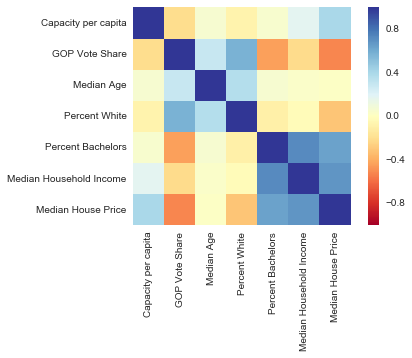

In [142]:
%matplotlib inline

sns.heatmap(solar_data.corr(), square=True, cmap='RdYlBu')

The GOP vote share in the 2016 Presidential Election, Median Age, Percentage of White People, Median Household income, and Median House Price are used as variables to predict solar capacity per capita. The heatmap above shows that each of the variables are highly intercorrelated with each other. 

## Machine learning with regression

We use the variables with machine learning in scikit-learn to find what predicts solar capacity. Since some of the variables are intercorrelated, we use regularized regression. 

In [143]:
from sklearn import model_selection
from sklearn import linear_model


# Split data into dependent and independent variables.
y = solar_data["Capacity per capita"].values
X = solar_data.drop(["Capacity per capita", "combined"], axis = 1).values

# Pick l1 ratio hyperparameter space

l1_space = np.linspace(0.00001, 1, 60)

# Setup cross validation and parameter search
elastic = linear_model.ElasticNetCV(l1_ratio = l1_space,
                                    normalize = True, cv = 10)

# Create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 21)

# Fit to the training set

elastic.fit(X_train, y_train)

# Check linear regression R^2

r2 = elastic.score(X_test, y_test)

print("Tuned ElasticNet Alpha {}".format(elastic.alpha_))
print("Tuned ElasticNet l1 ratio {}".format(elastic.l1_ratio_))
print("Tuned R squared {}".format(r2))



Tuned ElasticNet Alpha 6.380462749088242e-05
Tuned ElasticNet l1 ratio 0.01695898305084746
Tuned R squared 0.18461041526300404


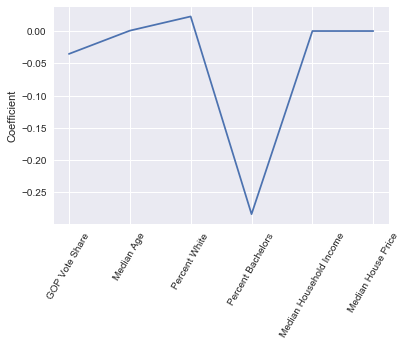

In [144]:
%matplotlib inline

elastic_coef = elastic.coef_

predictors = solar_data.drop(["Capacity per capita", "combined"], axis = 1).columns

plt.plot(range(len(predictors)), elastic_coef)
plt.xticks(range(len(predictors)), predictors.values, rotation = 60)
plt.ylabel("Coefficient")

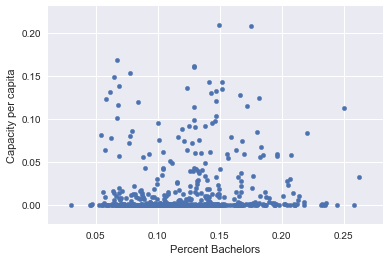

In [145]:
%matplotlib inline
fig, ax = plt.subplots(1)

solar_data.plot.scatter(x = 'Percent Bachelors', y = 'Capacity per capita', ax = ax)

In [146]:
print(elastic_coef)

[ -3.54717419e-02   5.87766627e-04   2.25825626e-02  -2.83869492e-01
  -5.91164547e-08   1.72012363e-07]
